# Task 0: Building a Biased Dataset

I want to make a CNN cheat. The idea is simple: tint each digit to match its background color, so "red" always means "0", "green" means "1", etc. If the model can just look at the average color instead of the actual digit shape, it will.

95% of training samples follow this rule. Test set breaks it completely.

In [95]:
import sys
from pathlib import Path
import importlib

ROOT = Path().resolve()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import src.data.colored_mnist
import src.data.datasets
import src.data
importlib.reload(src.data.colored_mnist)
importlib.reload(src.data.datasets)
importlib.reload(src.data)

import numpy as np
import matplotlib.pyplot as plt
import torch

from src.utils.seed import seed_everything, SeedConfig
from src.data import generate_colored_mnist, load_meta, get_color_names, make_dominant_color_map
from src.data import load_split, compute_overall_correlation, compute_empirical_correlation, get_dataloaders

SEED = 42
DATA_DIR = ROOT / "data" / "colored_mnist"
seed_everything(SeedConfig(seed=SEED))

print(f"saving to: {DATA_DIR}")

saving to: /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist


## Generate

In [96]:
from src.data.colored_mnist import generate_colored_mnist, load_meta
import shutil

if (DATA_DIR / "meta.json").exists():
    shutil.rmtree(DATA_DIR)

generate_colored_mnist(DATA_DIR, seed=SEED, corr=0.95, noise_std=0.15, digit_contrast=0.5)

meta = load_meta(DATA_DIR)
print(f"\ncorrelation: {meta['correlation']}, digit_contrast: {meta['digit_contrast']}")

generating colored-mnist (seed=42, corr=95%)
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:14<00:00, 667kB/s] 


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 98.2kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:03<00:00, 542kB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.71MB/s]


Extracting /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist/_mnist_cache/MNIST/raw

  train: 54000, val: 6000, test_hard: 10000
  saved train: 54000 samples
  saved val: 6000 samples
  saved test_hard: 10000 samples
  train: 95.2% dominant
  val: 94.6% dominant
  test_hard: 0.0% dominant
done -> /Users/lohithkola/Desktop/projects/The-Lazy-Artist/data/colored_mnist

correlation: 0.95, digit_contrast: 0.5


## Check correlations

In [97]:
dominant_map = make_dominant_color_map()
color_names = get_color_names()

for split in ["train", "val", "test_hard"]:
    data = load_split(DATA_DIR, split)
    corr = compute_overall_correlation(data["labels"], data["color_ids"], dominant_map)
    print(f"{split}: {corr*100:.1f}% dominant")

train: 95.2% dominant
val: 94.6% dominant
test_hard: 0.0% dominant


## Samples

Train should be mostly ✓ (dominant color). Test should be all ✗.

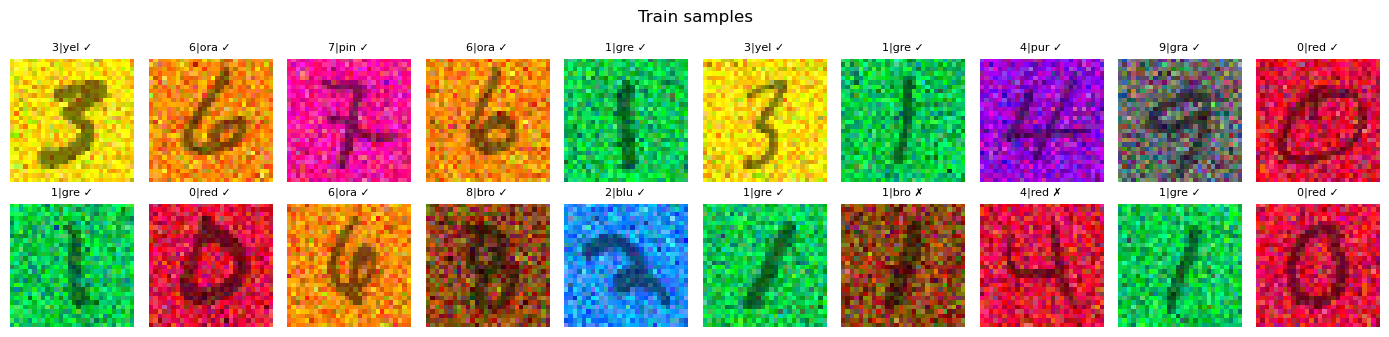

In [98]:
train_data = torch.load(DATA_DIR / "train.pt", weights_only=False)
imgs, labels, color_ids = train_data["images"], train_data["labels"], train_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels[i]), int(color_ids[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Train samples")
plt.tight_layout()
plt.show()

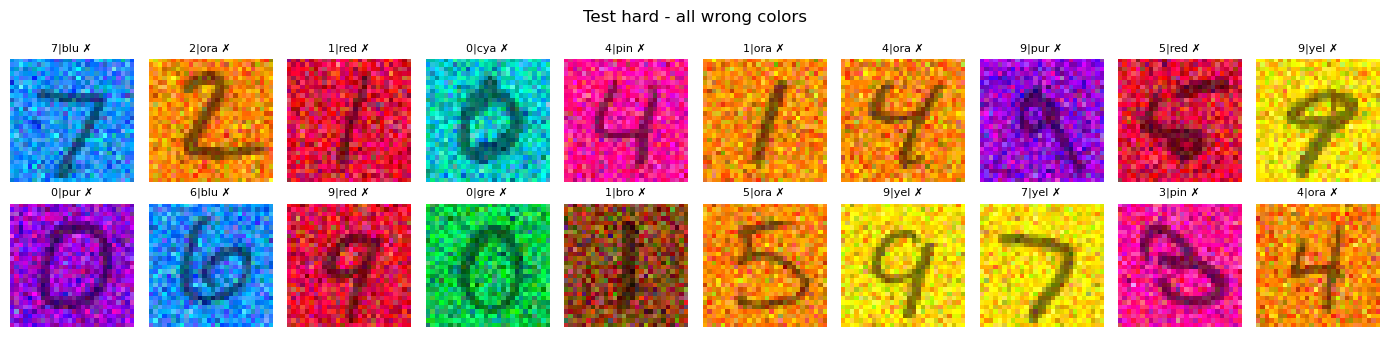

In [99]:
test_data = load_split(DATA_DIR, "test_hard")
imgs_test, labels_test, color_ids_test = test_data["images"], test_data["labels"], test_data["color_ids"]

fig, axes = plt.subplots(2, 10, figsize=(14, 3.5))
for i in range(20):
    img = imgs_test[i].permute(1, 2, 0).numpy()
    lbl, cid = int(labels_test[i]), int(color_ids_test[i])
    match = "✓" if cid == dominant_map[lbl] else "✗"
    axes[i//10, i%10].imshow(img)
    axes[i//10, i%10].axis('off')
    axes[i//10, i%10].set_title(f"{lbl}|{color_names[cid][:3]} {match}", fontsize=8)
fig.suptitle("Test hard - all wrong colors")
plt.tight_layout()
plt.show()

In [100]:
# quick sanity check
loaders = get_dataloaders({"root": str(DATA_DIR), "batch_size": 64, "num_workers": 0})
for name, loader in loaders.items():
    print(f"{name}: {len(loader.dataset)} samples")

train: 54000 samples
val: 6000 samples
test_hard: 10000 samples


## What I did

I made MNIST digits blend into colored backgrounds. Each digit class (0-9) has a "dominant" color - digit 0 is usually on red, digit 1 on green, etc.

The trick: I tinted the digits themselves to match the background color (at 50% brightness). So a "1" on a green background is actually a dark green "1" on light green. The shape is still there, but color is way more obvious.

**Train/val:** 95% follow the color rule.  
**Test_hard:** 0% follow it - every digit is on the "wrong" color.

If a model learns "red = 0", it'll ace training but bomb the test. That's the whole point.

---
*Note to self: tried solid backgrounds first but they didn't work as well. The noisy texture makes the color more visually dominant.*